### **Introduction** 

1. Read the input from

```shell
gs://cloud-samples-data/ai-platform-unified/datasets/tabular/petfinder-tabular-classification.csv
```

and load it in a Pandas Dataframe.

In [4]:
import scripts

In [31]:
from scripts.get_data import load_data

In [32]:
df = load_data()

2023-05-11 04:41:59,535 [INFO] Loading data from cloud-samples-data/ai-platform-unified/datasets/tabular/petfinder-tabular-classification.csv
2023-05-11 04:41:59,537 [INFO] Creating Google Cloud Storage client
2023-05-11 04:42:00,909 [INFO] Downloading blob 'ai-platform-unified/datasets/tabular/petfinder-tabular-classification.csv' from bucket 'cloud-samples-data'
2023-05-11 04:42:03,195 [INFO] Downloaded blob 'ai-platform-unified/datasets/tabular/petfinder-tabular-classification.csv' successfully
2023-05-11 04:42:03,197 [INFO] Reading CSV content from string
2023-05-11 04:42:03,230 [INFO] Successfully read CSV content and created DataFrame
2023-05-11 04:42:03,231 [INFO] DataFrame shape: (11537, 14)
2023-05-11 04:42:03,232 [INFO] DataFrame columns: Index(['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize',
       'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt',
       'Adopted'],
      dtype='object')
2023-05-11 04:42:03,244 [INFO] DataFrame's co

In [33]:
df.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,Yes
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,Yes
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,Yes
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,Yes
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,Yes


```Python
import io
import logging

import pandas as pd
from google.cloud import storage

# Configure logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s", handlers=[logging.StreamHandler()],
)


def create_storage_client():
    """
    Creates a client to interact with the Google Cloud Storage API.

    Returns:
        storage.Client: An instance of the storage client.
    """
    logging.info("Creating Google Cloud Storage client")
    return storage.Client()


def download_blob_as_string(storage_client, bucket_name, blob_name):
    """
    Downloads a blob from Google Cloud Storage (GCS) and returns its contents as a string.

    Args:
        storage_client (storage.Client): The storage client instance.
        bucket_name (str): The name of the GCS bucket.
        blob_name (str): The name of the blob to download.

    Returns:
        str: The contents of the blob as a string.
    """
    logging.info(f"Downloading blob '{blob_name}' from bucket '{bucket_name}'")
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(blob_name)
    content = blob.download_as_string()
    logging.info(f"Downloaded blob '{blob_name}' successfully")

    return content


def read_csv_from_string(csv_string):
    """
    Reads a CSV file from a string and returns its contents as a pandas DataFrame.

    Args:
        csv_string (str): The string containing the CSV content.

    Returns:
        pd.DataFrame: The parsed CSV content as a pandas DataFrame.
    """
    logging.info("Reading CSV content from string")
    dataframe = pd.read_csv(io.StringIO(csv_string.decode("utf-8")))
    logging.info("Successfully read CSV content and created DataFrame")

    return dataframe


def load_data(
    bucket_name="cloud-samples-data",
    file_name="ai-platform-unified/datasets/tabular/petfinder-tabular-classification.csv",
):
    """
    Main function to demonstrate the usage of the above functions.
    """
    logging.info(f"Loading data from {bucket_name}/{file_name}")

    storage_client = create_storage_client()
    csv_string = download_blob_as_string(storage_client, bucket_name, file_name)
    df = read_csv_from_string(csv_string)

    logging.info(f"DataFrame shape: {df.shape}")
    logging.info(f"DataFrame columns: {df.columns}")
    logging.info("DataFrame's content:\n" + str(df.head()))

    logging.info(f"Data has been successfully downloaded from {bucket_name}/{file_name}")
    return df


if __name__ == "__main__":
    load_data()


```

### **Preprocessing**

### Check for class imbalance in target variable

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
from scripts.preprocessing import one_hot_encode_columns,label_encode_columns,ordinally_encode_columns,count_encode_column
from scripts.config import CONFIG as config

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_class_distribution(df, column):
    class_counts = df[column].value_counts()

    # Calculate percentages
    class_percentages = class_counts / class_counts.sum() * 100

    plt.figure(figsize=(5,5))
    bars = plt.bar(class_percentages.index, class_percentages.values, width=0.9)

    # Remove top and right border
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Add percentages above the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom')
    
    plt.xlabel(column)
    plt.ylabel('Percentage')
    plt.title(f'Class distribution of the {column} variable (in %)')
    plt.show()

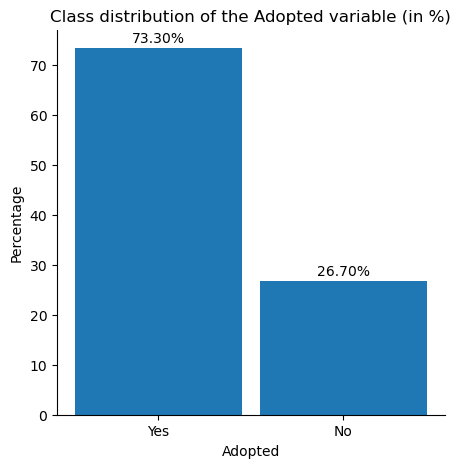

In [23]:
plot_class_distribution(df, 'Adopted')

#### One Hot Encode

In [24]:
columns_to_one_hot_encode = ["Type", "Gender"]

OneHotEncoding is a technique for handling categorical variables in ML. I chose it for these two fields
because they are nominal(have no inherent ordering). The two fields also have a relatively small number 
of categories so there won't be an explosion in the cardinality.

In [34]:
df = one_hot_encode_columns(df, config["one_hot_encode_columns"])

2023-05-11 04:42:10,148 [INFO] One-hot encoding columns: ['Type', 'Gender']


#### Label Encode

Here, the categorical values are assigned unique integer values
 - ["Vaccinated", "Sterilized", "Color1", "Color2"]

I could have one hot encoded the columns above but I didn't wanted
to reduce the number of features fed to the model

In [36]:
df = label_encode_columns(df, config["label_encode_columns"])

2023-05-11 08:16:24,680 [INFO] Label encoding columns: ['Vaccinated', 'Sterilized', 'Color1', 'Color2']


#### Ordinal Encoding

Ordinal Encoding is similar to Label Encoding but it's used for ordinal variables, where the order of the categories is important.<br>
The integers are assigned in a way that respects the order of the categories. For example, in the category <br>
"Low", "Medium", "High", "Low" might be encoded as 0, "Medium" as 1, and "High" as 2.

```Python
{
        "Health": ["Healthy", "Minor Injury", "Serious Injury"],
        "FurLength": ["Short", "Medium", "Long"],
        "MaturitySize": ["Small", "Medium", "Large"],
    },
```

In [37]:
df = ordinally_encode_columns(df, config["ordinal_encode_columns"])

2023-05-11 08:22:05,374 [INFO] Ordinally encoding columns: dict_keys(['Health', 'FurLength', 'MaturitySize'])


#### Count Encoding

Count encoding is a technique used for converting categorical data into a form that can be used by machine learning algorithms.<br>
With count encoding, each category in a categorical variable is replaced with the count of the number of times the category appears in the dataset.

In [39]:
df = count_encode_column(df, config["count_encode_column"])

2023-05-11 08:25:47,683 [INFO] Count encoding column: Breed1


### **Train the model**

In [41]:
from scripts.train import split_dataset